Playing around with the `h5py` library...

In [1]:
import os

import cartopy

import datetime as dt
import h5py as h5
import matplotlib as mpl
import numpy as np
import pandas as pd

from pathlib import Path as path
from matplotlib import pyplot as plt

In [2]:
# create variables holding paths to input data
DATA_DIR = os.path.join('..', 'data')
INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
SMAP_DATA_DIR = os.path.join(INPUT_DATA_DIR, 'SMAP', 'SPL3SMP.005')

# file suffix pattern for the SMAP files of interest
SMAP_FILE_SUFFIX = '*_R16010_001.h5'

# get paths to all HDF5 files ending with SMAP_FILE_SUFFIX
# found in all directories within SMAP_DATA_DIR
DATA_PATHS = sorted([str(filepath) for filepath in path(SMAP_DATA_DIR).rglob(SMAP_FILE_SUFFIX)])

# get the first in path DATA_PATHS to use for testing
TEST_DATA_PATH = DATA_PATHS[0]

# the HDF5 files contain many datasets, but
# the soil_moisture dataset is what we're interested in
SM_DATASET_NAME = 'soil_moisture'

# create variables to hold path to files containing EASE grid lat/lons (used for plotting)
# data source: https://github.com/TUW-GEO/ease_grid/tree/master/tests/test_data
EASE_GRID_DIR = os.path.join(DATA_DIR, 'ease_grid')
EASE_LATS_PATH = os.path.join(EASE_GRID_DIR, 'EASE2_M36KM.lats.964x406x1.double')
EASE_LONS_PATH = os.path.join(EASE_GRID_DIR, 'EASE2_M36KM.lons.964x406x1.double')

# store the EPSG projection code for the EASE Grid
# that this data uses (not used in this notebook)
EASE_CRS = 'epsg:6933'

# create a path to an output directory in case
# we want to save files at some point
OUTPUT_DIR = os.path.join(DATA_DIR, 'output')

# check if OUTPUT_DIR exists and, if not, create it
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    
FIG_SIZE = (30, 10)

In [3]:
# read EASE2 lat/lons and then reshape from a 1D to 2D array matching the EASE Grid shape (EASE_SHAPE)
EASE_SHAPE = (406, 964)
EASE_LATS = np.fromfile(EASE_LATS_PATH, dtype=np.float64).reshape(EASE_SHAPE)
EASE_LONS = np.fromfile(EASE_LONS_PATH, dtype=np.float64).reshape(EASE_SHAPE)

In [4]:
def print_dataset_names(src_path: str):
    '''
    Print name of datasets in file at src_path.
    '''
    
    print(f'Datasets contained in: {src_path}', end='\n\n')
    
    # open file at src_path with rasterio
    with h5.File(src_path, 'r') as src:
        for subdataset in src.keys():
            print(subdataset)
            for dataset in src.get(subdataset).keys():
                print(" |--", dataset)

In [5]:
print_dataset_names(TEST_DATA_PATH)

Datasets contained in: ../data/input/SMAP/SPL3SMP.005/2017.03.01/SMAP_L3_SM_P_20170301_R16010_001.h5

Metadata
 |-- AcquisitionInformation
 |-- DataQuality
 |-- DatasetIdentification
 |-- Extent
 |-- GridSpatialRepresentation
 |-- Lineage
 |-- OrbitMeasuredLocation
 |-- ProcessStep
 |-- ProductSpecificationDocument
 |-- QADatasetIdentification
 |-- SeriesIdentification
Soil_Moisture_Retrieval_Data_AM
 |-- EASE_column_index
 |-- EASE_row_index
 |-- albedo
 |-- boresight_incidence
 |-- freeze_thaw_fraction
 |-- grid_surface_status
 |-- landcover_class
 |-- landcover_class_fraction
 |-- latitude
 |-- latitude_centroid
 |-- longitude
 |-- longitude_centroid
 |-- radar_water_body_fraction
 |-- retrieval_qual_flag
 |-- roughness_coefficient
 |-- soil_moisture
 |-- soil_moisture_error
 |-- static_water_body_fraction
 |-- surface_flag
 |-- surface_temperature
 |-- surface_water_fraction_mb_h
 |-- surface_water_fraction_mb_v
 |-- tb_3_corrected
 |-- tb_4_corrected
 |-- tb_h_corrected
 |-- tb_h_

In [6]:
def read_metadata(src_path: str):
    with h5.File(src_path, 'r') as src:
        meta = src.get('Metadata')
        for item in meta.keys():
            print(item)
            for subitem in meta[item].keys():
                print('  |--', subitem)
                for subsubitem in meta[item][subitem].attrs.keys():
                    value = meta[item][subitem].attrs[subsubitem]
                    
                    if type(value) == bytes:
                        print('      |--', value.decode('UTF-8'))
                    else:
                        print('      |--', value)
    return meta

In [7]:
read_metadata(TEST_DATA_PATH)

AcquisitionInformation
  |-- platform
      |-- 14.6
      |-- The SMAP observatory houses an L-band radiometer that operates at 1.414 GHz and an L-band radar that operates at 1.225 GHz.  The instruments share a rotating reflector antenna with a 6 meter aperture that scans over a 1000 km swath.  The bus is a 3 axis stabilized spacecraft that provides momentum compensation for the rotating antenna.
      |-- SMAP
  |-- platformDocument
      |-- JPL CL#14-2285, JPL 400-1567
      |-- 2014-07-01
      |-- SMAP Handbook
  |-- radar
      |-- The SMAP 1.225 GHz L-Band Radar Instrument
      |-- SMAP SAR
      |-- L-Band Synthetic Aperture Radar
  |-- radarDocument
      |-- JPL CL#14-2285, JPL 400-1567
      |-- 2014-07-01
      |-- SMAP Handbook
  |-- radiometer
      |-- The SMAP 1.414 GHz L-Band Radiometer
      |-- SMAP RAD
      |-- L-Band Radiometer
  |-- radiometerDocument
      |-- JPL CL#14-2285, JPL 400-1567
      |-- 2014-07-01
      |-- SMAP Handbook
DataQuality
  |-- Completen

<Closed HDF5 group>

In [8]:
def parse_date(src_path: str):
    
    date_str = src_path.split('_')[4]
    date = dt.datetime.strptime(date_str, '%Y%m%d')
    
    return date

In [9]:
def read_dataset(src_path: str, target_dataset: str, target_subdataset: str, mask_nodata: bool = True):
    '''
    Read dataset_name in HDF5 file at src_path.
    '''
    # open the file with h5py
    with h5.File(src_path, 'r') as src:
        
        datasets = list(filter(lambda x: x.endswith(target_dataset), src.keys()))
        
        assert len(datasets), f'No datasets match target: {target_dataset}'
        
        for dataset in datasets:
            
            subdatasets = list(filter(lambda x: x.endswith(target_subdataset), src[dataset].keys()))
            
            assert len(subdatasets), f'No subdatasets match target: {target_subdataset}'
            
            for subdataset in subdatasets:
                
                if subdataset == target_subdataset:
                
                    data = np.array(src[dataset][subdataset])
                    
                    attrs = dict(src[dataset][subdataset].attrs)
                    attrs['crs'] = EASE_CRS
                    attrs['date'] = parse_date(src_path)
                    attrs['short_name'] = target_subdataset
                    
                    if mask_nodata:
                        nodata = attrs['_FillValue']
                        data[data == nodata] = np.nan
    
    return data, attrs             

In [10]:
def plot_data(data: np.ndarray, \
                    attrs, \
                    lats: np.ndarray = EASE_LATS, lons: np.ndarray = EASE_LONS, \
                    projection: str = 'cyl', extent: list = None, \
                      cmap: str = 'viridis_r'):

    '''
    Plot data.
    '''
    
    # extract some useful metadata (e.g., units, valid min/max)
    long_name, short_name, units, vmin, vmax = (None, None, None, None, None)

    for descriptor in attrs.keys():
        if 'long_name' in descriptor:
            long_name = attrs[descriptor].decode('utf-8')
        elif 'short_name' in descriptor:
            short_name = attrs[descriptor]
        elif 'units' in descriptor:
            units = attrs[descriptor].decode('utf-8')
        elif 'valid_min' in descriptor:
            vmin = attrs[descriptor]
        elif 'valid_max' in descriptor:
            vmax = attrs[descriptor]
    
    # define the plot size and create an axis object (ax) to plot on
    fig, ax = plt.subplots(figsize=FIG_SIZE, subplot_kw={'projection': cartopy.crs.PlateCarree()})

#     ax = plt.axes(projection=cartopy.crs.PlateCarree())
    
    # want to zoom in? set the extent of the plot
    if extent:
        ax.set_extent(extent)

    # plots need titles! this uses the long-name found in the add'l metadata
    # pad=40 moves the tile up so it doesn't cover lat/lon labels added later
    ax.set_title(long_name[:-1].upper(), pad=20)

    # plot the actual data!
    plot = ax.pcolor(lons, lats, data, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # add a color bar with units labeled
    cax, kwargs = mpl.colorbar.make_axes(ax, location='bottom', pad=0.05, shrink=0.5)
    cbar = fig.colorbar(plot, cax=cax, **kwargs)
    cbar.set_label(f'{short_name.upper()} ({units})', size=10)

    # add global coastlines to the plot
    ax.coastlines(resolution='110m')
    
    # add country borders to the plot
    ax.add_feature(cartopy.feature.BORDERS)

    # add lat/lon lines and labels 
    ax.gridlines(draw_labels=True)
    
    # add gray land
    ax.add_feature(cartopy.feature.LAND, color ='lightgray')
    
    # water should look like water!
    ax.add_feature(cartopy.feature.RIVERS, color='lightblue')
    ax.add_feature(cartopy.feature.OCEAN, color='lightblue')

    # the big reveal...
    return ax

/Users/brendanmcandrew/miniconda3/envs/smap-vis-env/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


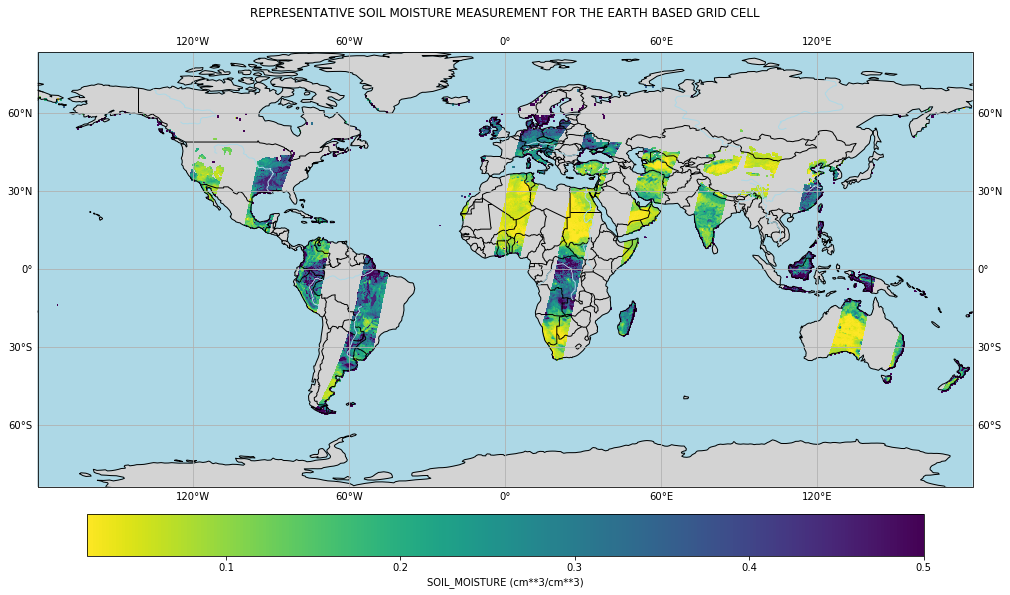

In [11]:
test_data, test_attrs = read_dataset(TEST_DATA_PATH, 'AM', SM_DATASET_NAME)
plot_data(test_data, test_attrs)

In [12]:
def stack_datasets(data_paths: list, target_dataset: str, target_subdataset: str, mask_nodata: bool = True):
    '''
    Read in 2d arrays and stack as 3d arrays.
    '''

    # create some empty variables that we'll add to
    data_3d = np.empty([EASE_SHAPE[0], EASE_SHAPE[1], len(data_paths)])
    attrs = []
    
    # loop over the paths to each file
    for i, data_path in enumerate(data_paths, 0):
        
        # read each dataset
        data_i, attrs_i = read_dataset(data_path, target_dataset, target_subdataset, mask_nodata)
        
        # append the 2d array to the 3d array and attrs_i to attrs list
        data_3d[:, :, i] = data_i
        attrs.append(attrs_i)

    # return the data, metadata, and add'l metadata
    return data_3d, attrs

In [13]:
def calc_mean(data_stack: np.ndarray, axis: int=2):
    return np.nanmean(data_stack, axis=axis)

In [14]:
def plot_mean(data_paths: list=DATA_PATHS, dataset: str='AM', subdataset: str=SM_DATASET_NAME,
             extent: list=None):
    '''
    Calculate and plot mean of the specified dataset across files contained DATA_PATHS.
    '''
    
    stack_data, attrs = stack_datasets(data_paths, dataset, subdataset)
    mean_data = calc_mean(stack_data)
    return plot_data(mean_data, attrs[0], extent=extent)

In [15]:
test_stack, test_stack_attrs = stack_datasets(DATA_PATHS, 'AM', SM_DATASET_NAME)

In [16]:
test_stack.shape

(406, 964, 184)

<ipython-input-13-5dee61c67ca9>:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(data_stack, axis=axis)


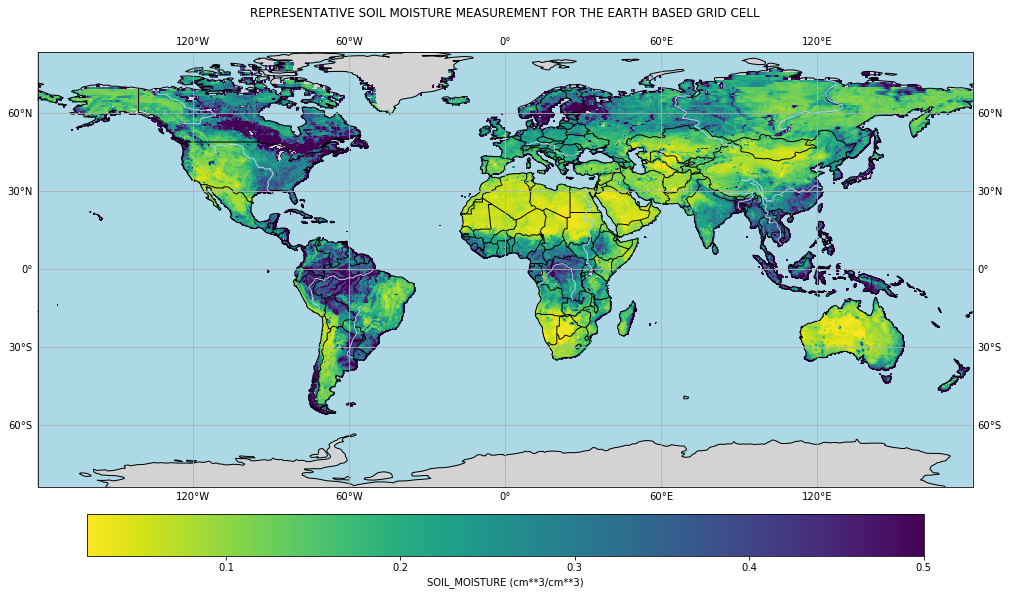

In [17]:
plot_mean()

In [18]:
test_mean = calc_mean(test_stack)

<ipython-input-13-5dee61c67ca9>:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(data_stack, axis=axis)


In [19]:
def map_color(df, variable):
    norm = mpl.colors.Normalize(vmin=df[variable].min(), vmax=df[variable].max(), clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis_r)
    df['color'] = df.apply(lambda x: mapper.to_rgba(x[variable]), axis=1)
    return df

In [20]:
def plot_data_bars(data: np.ndarray, \
                    attrs, \
                    lats: np.ndarray = EASE_LATS, lons: np.ndarray = EASE_LONS, \
                    projection: str = 'cyl', extent: list = None, \
                      cmap: str = 'viridis_r'):

    '''
    Plot data.
    '''
    
    # definitions for the axes
    left, width = 0.1, 1
    bottom, height = 0.1, 0.5
    spacing = 0
    
    rect_map = [left, bottom, width, height]
    rect_lon_bar = [left, bottom + height + spacing, width, 0.1]
    rect_lat_bar = [left + width + spacing, bottom, 0.1, height]
    
    # extract some useful metadata (e.g., units, valid min/max)
    long_name, short_name, units, vmin, vmax = (None, None, None, None, None)

    for descriptor in attrs.keys():
        if 'long_name' in descriptor:
            long_name = attrs[descriptor].decode('utf-8')
        elif 'short_name' in descriptor:
            short_name = attrs[descriptor]
        elif 'units' in descriptor:
            units = attrs[descriptor].decode('utf-8')
        elif 'valid_min' in descriptor:
            vmin = attrs[descriptor]
        elif 'valid_max' in descriptor:
            vmax = attrs[descriptor]
    
    # define the plot size and create an axis object (ax) to plot on
    fig = plt.figure(figsize=FIG_SIZE)
    
    ax_map = plt.axes(rect_map, projection=cartopy.crs.PlateCarree())
    ax_lat_bar = plt.axes(rect_lat_bar)
    ax_lat_bar.tick_params(labelbottom=False)
    ax_lon_bar = plt.axes(rect_lon_bar)
    ax_lon_bar.tick_params(labelleft=False)
    
    
    
    # want to zoom in? set the extent of the plot
    if extent:
        ax.set_extent(extent)

    # plots need titles! this uses the long-name found in the add'l metadata
    # pad=40 moves the tile up so it doesn't cover lat/lon labels added later
    ax_map.set_title(long_name[:-1].upper(), pad=20)

    # plot the actual data!
    plot = ax_map.pcolor(lons, lats, data, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # add a color bar with units labeled
#     cax, kwargs = mpl.colorbar.make_axes(ax_map, location='bottom', pad=0.05, shrink=0.5)
#     cbar = fig.colorbar(plot, cax=cax, **kwargs)
#     cbar.set_label(f'{short_name.upper()} ({units})', size=10)

    # add global coastlines to the plot
    ax_map.coastlines(resolution='110m')
    
    # add country borders to the plot
    ax_map.add_feature(cartopy.feature.BORDERS)

    # add lat/lon lines and labels 
    ax_map.gridlines(draw_labels=True)
    
    # add gray land
    ax_map.add_feature(cartopy.feature.LAND, color ='lightgray')
    
    # water should look like water!
    ax_map.add_feature(cartopy.feature.RIVERS, color='lightblue')
    ax_map.add_feature(cartopy.feature.OCEAN, color='lightblue')

    # the big reveal...
    
    lat_mean_df = pd.DataFrame({'lat_mean': np.nanmean(data, axis=1)})
    lon_mean_df = pd.DataFrame({'lon_mean': np.nanmean(data, axis=0)})
    
    lon_mean_df = map_color(lon_mean_df, 'lon_mean')
    lon_mean_df.set_index(EASE_LONS[0], inplace=True)
    lat_mean_df = map_color(lat_mean_df, 'lat_mean')
    lat_mean_df.set_index(EASE_LATS[:,0], inplace=True)
    
    ax_bar_lon.bar(lon_mean_df.index, lon_mean_df['lon_mean'], width=1.0)
    ax_bar_lat.barh(lat_mean_df.index, lat_mean_df['lat_mean'], height=1.0)
    
#     return fig

<ipython-input-20-9ad18ae5a9dc>:80: RuntimeWarning: Mean of empty slice
  lat_mean_df = pd.DataFrame({'lat_mean': np.nanmean(data, axis=1)})
<ipython-input-20-9ad18ae5a9dc>:81: RuntimeWarning: Mean of empty slice
  lon_mean_df = pd.DataFrame({'lon_mean': np.nanmean(data, axis=0)})


NameError: name 'ax_bar_lon' is not defined

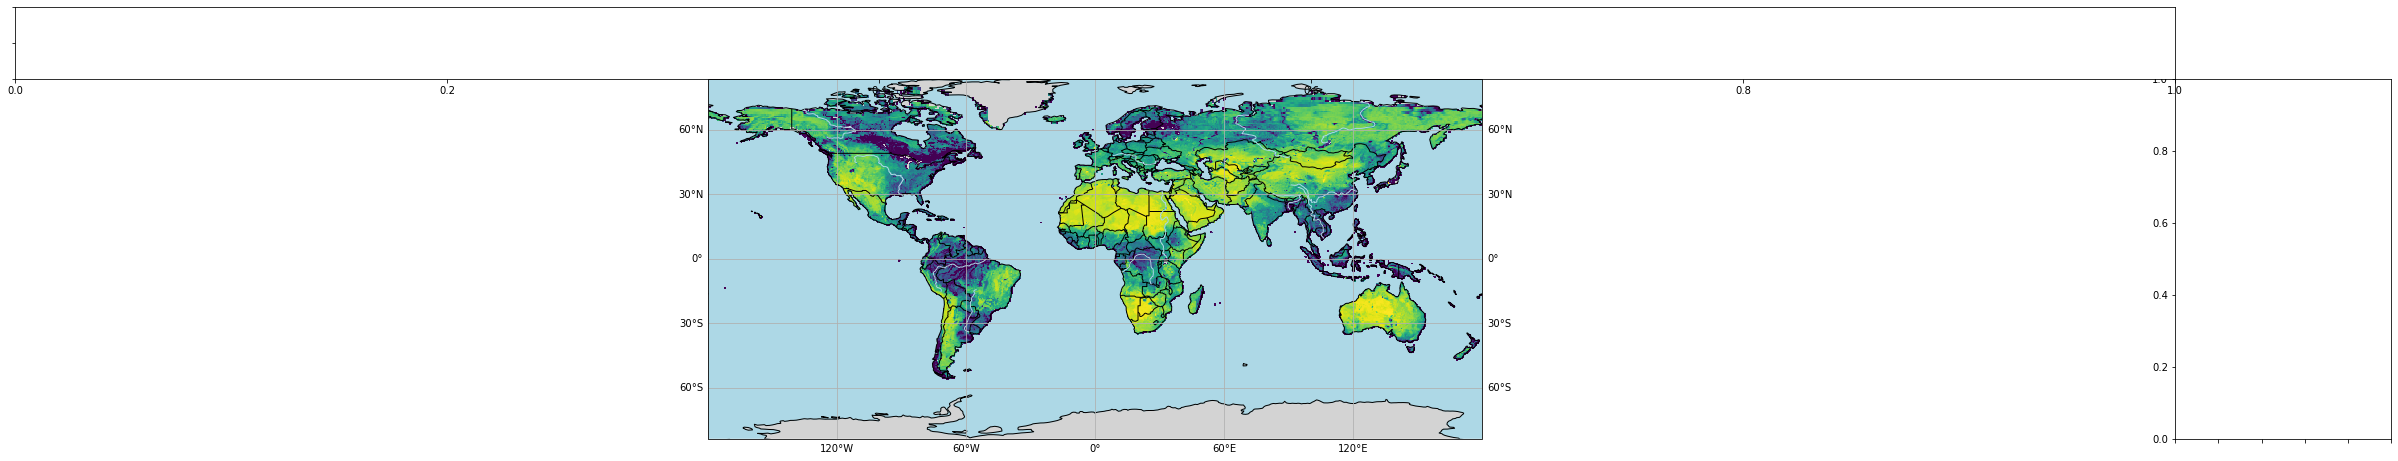

In [21]:
plot_data_bars(test_mean, test_stack_attrs[0])

In [22]:
lon_mean_df = map_color(lon_mean_df, 'lon_mean')
lon_mean_df.set_index(EASE_LONS[0], inplace=True)
lat_mean_df = map_color(lat_mean_df, 'lat_mean')
lat_mean_df.set_index(EASE_LATS[:,0], inplace=True)

NameError: name 'lon_mean_df' is not defined

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
ax_map = plot_mean()
ax_map.set_aspect(1.)
ax_map.xaxis.set_tick_params(labeltop=False)
ax_map.yaxis.set_tick_params(labelright=False)

divider = make_axes_locatable(ax_map)
ax_bar_lon = divider.append_axes("top", size=(30, 1), pad=0, sharex=ax_map, map_projection=cartopy.crs.PlateCarree())
ax_bar_lat = divider.append_axes("right", size=(1, 10), pad=0, sharey=ax_map, map_projection=cartopy.crs.PlateCarree())

# make some labels invisible
ax_bar_lon.xaxis.set_tick_params(labelbottom=False)
ax_bar_lat.yaxis.set_tick_params(labelleft=False)

ax_bar_lon.bar(lon_mean_df.index, lon_mean_df['lon_mean'], width=1.0)
ax_bar_lat.barh(lat_mean_df.index, lat_mean_df['lat_mean'], height=1.0)

# lon_mean_df.plot(kind='bar', y='lon_mean', color=lon_mean_df['color'], ax=ax_bar_lon, width=1.0)
# lat_mean_df.plot(kind='barh', y='lat_mean', color=lat_mean_df['color'], ax=ax_bar_lat, width=1.0)

In [24]:
n_lat = 38.5
w_lon = -6
s_lat = 25.5
e_lon = 6

subset_coords = [w_lon, e_lon, n_lat, s_lat]

subset = (EASE_LATS < n_lat) & (EASE_LATS > s_lat) & (EASE_LONS > w_lon) & (EASE_LONS < e_lon)

sm_time = np.empty([len(DATA_PATHS)])
anomaly_time = np.empty([EASE_SHAPE[0], EASE_SHAPE[1], len(DATA_PATHS)])

for i in np.arange(0, test_stack.shape[2]):
    sm_2d = test_stack[:, :, i]
    sm_2d_subset = sm_2d[subset]
    sm_time[i] = np.nanmean(sm_2d_subset)
    anomaly_time[:,:,i] = sm_2d - test_mean

mean_df = pd.DataFrame({'mean_sm': sm_time})
mean_df['date'] = [attrs['date'] for attrs in test_stack_attrs]

mean_df.set_index('date', inplace=True)

# mean_plot = plot_mean(extent=[w_lon+1, e_lon-1, n_lat+1, s_lat-1])
# mean_plot.add_feature(cartopy.feature.STATES)

In [25]:
anomaly_time.shape

(406, 964, 184)

Text(0, 0.5, 'Soil Moisture (${cm^3/cm^3}$)')

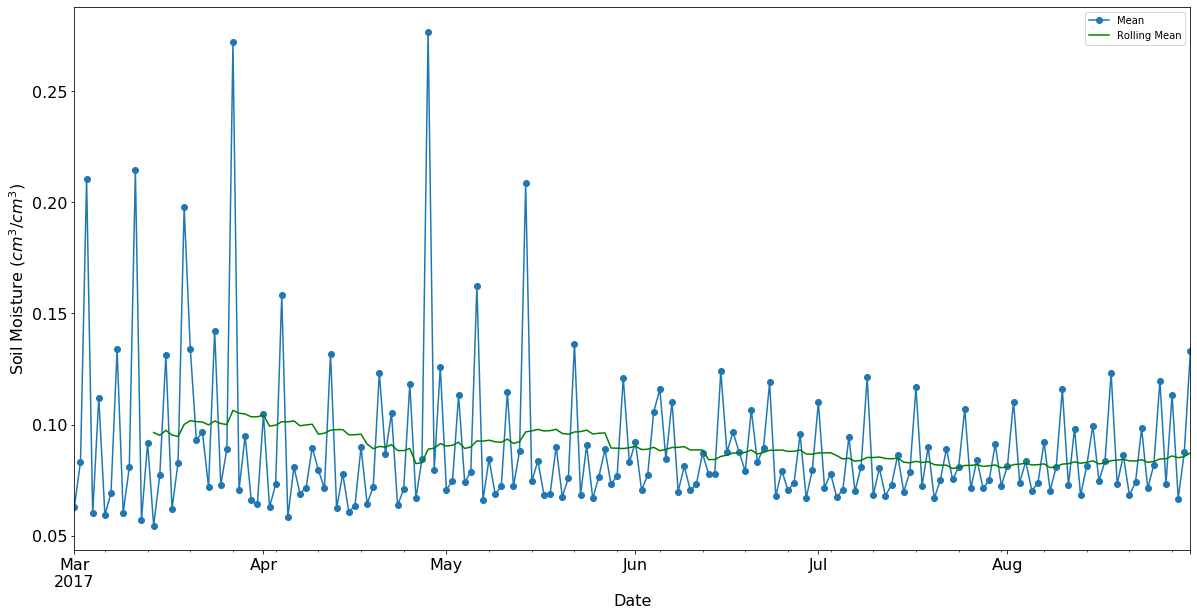

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))

mean_df.columns = ['Mean']
mean_df.plot(marker='o', ax=ax)

roll_window = '30D'
min_periods = 14

rolling_mean = mean_df.rolling(window=roll_window, min_periods=min_periods, axis=0).mean()
rolling_mean.columns = ['Rolling Mean']
rolling_mean.plot(color='green', ax=ax)

labelsize = 16
ax.tick_params(axis = 'both', which = 'major', labelsize = labelsize)

ax.set_xlabel('Date', fontsize=labelsize)
ax.set_ylabel('Soil Moisture (${cm^3/cm^3}$)', fontsize=labelsize)

In [27]:
anomaly_df = mean_df.join(rolling_mean)
total_mean = mean_df['Mean'].mean()
anomaly_df['anomaly'] = anomaly_df.apply(lambda row: total_mean - row['Rolling Mean'], axis=1)

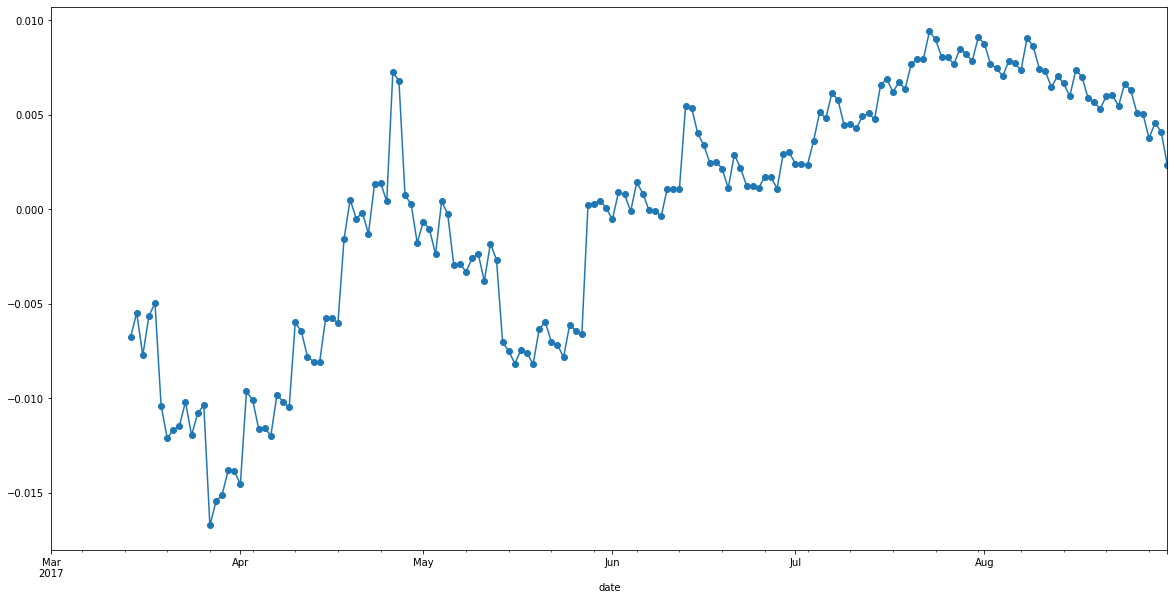

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
anomaly_df['anomaly'].plot(marker='o')

In [ ]:
mean_df.groupby(mean_df.index.month).mean()